In [1]:
##Create train, dev/val,test
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:

words = open('names.txt', 'r').read().splitlines()
random.seed(42)
random.shuffle(words)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

#Building the dataset - very similar to the trigram construction but dynamic
def prepare_data(data, block_size):

    block_size = block_size #alternative for context length

    X, Y = [], []

    for w in data:

        #print(w, '--- word of interest')
        context = [0] * block_size #How many characters to consider from the left to the right
        for ch in w + '.': #adding end word
            
            ix = stoi[ch]

            X.append(context)
            Y.append(ix)

            #print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] #context is redefined as a new list and we move the window to the right


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [3]:
train_limit = int(0.8*len(words))
dev_limit = int(0.9*len(words))
block_size = 3

Xtr, Ytr = prepare_data(words[:train_limit], block_size = block_size)
Xdev, Ydev = prepare_data(words[train_limit:dev_limit], block_size = block_size)
Xtest, Ytest = prepare_data(words[dev_limit:], block_size = block_size)

In [4]:

for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [5]:
Xtr[0], Ytr[0]

(tensor([0, 0, 0]), tensor(25))

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.fan_in = fan_in
    self.fan_out = fan_out
    self.weight = torch.randn((self.fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(self.fan_out) if bias else None

  
  def __call__(self, x):

    #Forward pass
    self.out = x @ self.weight

    #Adding the biases if needed
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def __repr__(self):
      """Prints the class representation."""
      if self.bias is None:
          return f"{self.__class__.__name__}(fan_in={self.fan_in}, fan_out={self.fan_out}, bias={False})"
      return f"{self.__class__.__name__}(fan_in={self.fan_in}, fan_out={self.fan_out}, bias={True})"
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias]) #learnable parameters
  
#___________________________

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):

    #Epsilon is a small value used for preventing the perfect nullity of variance
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.dim = dim
    # parameters (trained with backprop)
    self.gamma = torch.ones(self.dim)
    self.beta = torch.zeros(self.dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(self.dim)
    self.running_var = torch.ones(self.dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
      
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta 
    
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def __repr__(self):
    """Prints the class representation."""
        
    return f"{self.__class__.__name__}(dim={self.dim}, eps={self.eps}, momentum={self.momentum}, training={self.training})"
  

  def parameters(self):
    return [self.gamma, self.beta] #learnable parameters

#__________________________________________________

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def __repr__(self):
    """Prints the class representation."""
        
    return f"{self.__class__.__name__}()"
  

  def parameters(self):
    return []
  

  #_____________ embedding layer

  class Embedding: 

    def __init__(self, num_embeddings, embedding_dim):
      self.weight = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, IX):
      try:
        #Forward pass
        self.out = self.weight[IX]
      except Exception as e: 
        print(f'Error at embedding indexing: {e}')
        print('Returning the randomly initialized embdding matrix')
        self.out = self.weight
      
      return self.out
    
    def parameters(self):
      return [self.weight]

    
    def __repr__(self):
      """Prints the class representation."""
          
      return f"{self.__class__.__name__}(embed_dimensions={self.weight.shape}"


#________
class Flatten:

  def __call__(self, x):
    self.out = x.vew(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

In [7]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 300 # the number of neurons in the hidden layer of the MLP
vocab_size = len(stoi.keys())
C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=True), BatchNorm1d(vocab_size),
]


with torch.no_grad():
  
  pass 
  # all other layers: apply gain when not using batch normalization
  # for layer in layers[:-1]:
  #   if isinstance(layer, Linear):
  #     #layer.weight *= 0
  #     layer.weight *= 5/3 ###gain section

  #make the last layer less confident for some reason. 
  #layers[-1].weight *= 0.1
  
      
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f' Number of parameters:', sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

 Number of parameters: 381951


In [8]:
C.shape, block_size, C[Xtr[:2]].shape

(torch.Size([27, 10]), 3, torch.Size([2, 3, 10]))

In [9]:
ex_emb = C[Xtr[:2]]
print(f'ex_emb shape pre view {ex_emb.shape}')
new_shape = ex_emb.view(ex_emb.shape[0], -1)
print(f'ex_emb shape post view {new_shape.shape}')

ex_emb shape pre view torch.Size([2, 3, 10])
ex_emb shape post view torch.Size([2, 30])


## Deprec layer organization
- why do we keep embedding layer operations (view) and indexing outside of layer organization 

In [ ]:
max_steps = 20000
batch_size = 32
lossi = []
n = batch_size # a shorter variable also, for convenience


for i in range(max_steps):

    if i % 1000 == 0:
        print(f'{i} / {max_steps}')

    #batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    #forward pass - should be optimized 
    emb = C[Xb]
    x = emb.view(emb.shape[0],  -1) #change the shape of the embedding 
    
    "We want to stack the embeddings to so that we concatenatve all 3 letters into one row"
    for layer in layers: 
        x = layer(x) 

    #Calculate the loss
    loss = F.cross_entropy(x, Yb)

      
    # This is for storing the gradients for additional investigations
    # for layer in layers:
    #     layer.out.retain_grad() # This is for gathering stats below. When done with debugging we can turn this off.


    #re-set the gradients prior to calculating the loss
    for p in parameters:
        p.grad = None

    #backward pass
    loss.backward()

    # update data with learning rate times the gradients. 
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #Track the loss information, make sure to grab the item itself!
    lossi.append(loss.log10().item())

0 / 20000
1000 / 20000
2000 / 20000
3000 / 20000
4000 / 20000
5000 / 20000
6000 / 20000
7000 / 20000
8000 / 20000
9000 / 20000
10000 / 20000
11000 / 20000
12000 / 20000
13000 / 20000
14000 / 20000
15000 / 20000
16000 / 20000
17000 / 20000
18000 / 20000
19000 / 20000


## Lets improve our layer structures
- build embedding layers and embedding layer look up
- pytorchify the viewing option

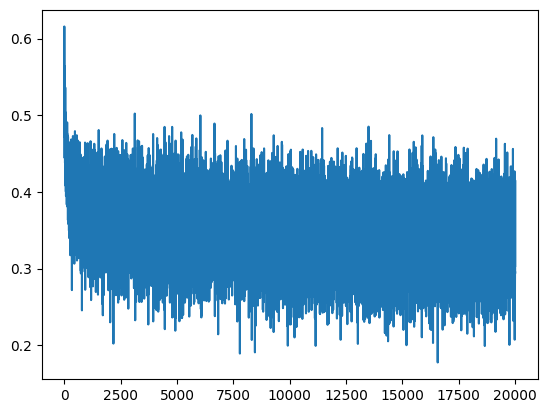

In [11]:
#Show the plot for the loss 
plt.plot(lossi)


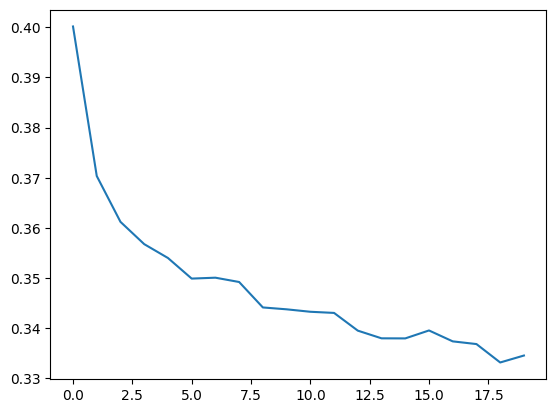

In [12]:
#Loss i plot improvements
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [13]:
#Lets go into eval mode.
for layer in layers:
    layer.training = False



In [14]:
#Evaluation set performance
@torch.no_grad

def split_specific_loss(split):
    
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]

    #use the trained C
    emb = C[x]

    x = emb.view(emb.shape[0], -1)

    for layer in layers: 
        x = layer(x)

    loss = F.cross_entropy(x,y)

    print(f'{split}  ---  {loss}')

split_specific_loss('train')

split_specific_loss('val')


train  ---  2.127512216567993
val  ---  2.1597342491149902


In [15]:
#Lets sample from the model


for _ in range(20):

    output = []

    context = [0] * block_size

    while True: 

        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)

        for layer in layers: 
            x  = layer(x)

        logits = x

        #print(f'This is the logits shape: {logits.shape}')
        probs = F.softmax(logits, dim = 1) #normalized

        ix = torch.multinomial(probs, num_samples = 1).item()

        context = context[1:] + [ix]
        output.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[ix] for ix in output))










sayia.
marrice.
oditlyn.
dey.
make.
jer.
tayshamiean.
sali.
esse.
trekiah.
baynah.
eziah.
mizoldeine.
rari.
darmarion.
rode.
lana.
ty.
yolamin.
xyance.


In [16]:
-F.softmaxlogits

AttributeError: module 'torch.nn.functional' has no attribute 'softmaxlogits'